# **Problem Description**

Obesity a growing public health concern worldwide, linked to various chronic diseases, including diabetes, cardiovascular issues, and certain types of cancer. Addressing obesity requires a deep understanding of the factors influencing its prevalence, including eating habits, physical activity, and lifestyle choices. This problem aims to leverage unsupervised learning techniques to classify individuals into meaningful clusters based on their characteristics, which include dietary habits, physical condition, and lifestyle patterns, to estimate obesity levels.

The dataset used for my analysis includes a variety of features related to an individual's demographic information (e.g., gender, age), physical measurements (e.g., height, weight), eating behaviors (e.g., fast food consumption, calorie intake), and activity levels (e.g., physical activity frequency, transportation modes). Notably, the dataset does not initially contain explicit labels indicating obesity levels, making it an ideal candidate for unsupervised learning.

The primary goals of my analysis is:
1. **Clustering Individuals:** Segment individuals into distinct groups that reflect similarities in their dietary and lifestyle behaviors.
2. **Understanding Cluster Characteristics:** Interpret the resulting clusters to identify key patterns that distinguish different groups.
3. **Association with Obesity Levels:** Evaluate the alignment of the identified clusters with known obesity levels to validate the clustering approach.

### **Challenges**
1. **Heterogeneous Data Types:** The dataset contains both numerical (e.g., age, BMI) and categorical variables (e.g., transportation modes, smoking habits), necessitating careful preprocessing, including encoding and scaling.
2. **Feature Complexity:** Some variables, such as BMI, are derived from existing features (e.g., height and weight), requiring additional feature engineering to create meaningful representations.
3. **Cluster Interpretability:** Beyond forming clusters, it is essential to ensure that these clusters are interpretable and provide actionable insights into the factors influencing obesity.
4. **Evaluation Without Ground Truth:** As this is an unsupervised learning problem, the absence of explicit ground truth for clustering necessitates the use of intrinsic clustering metrics (e.g., silhouette score, Davies-Bouldin index) and external validation against labeled data for alignment with obesity levels.

### **Approach**
1. **Exploratory Data Analysis (EDA):**
   - Perform statistical summaries and visualizations to understand data distributions and relationships.
   - Create new features, such as BMI and interaction terms (e.g., age × physical activity frequency), to enhance clustering performance.

2. **Data Preprocessing:**
   - Scale numerical features and encode categorical variables using a combination of one-hot and ordinal encoding to ensure compatibility with clustering algorithms.
   - Apply dimensionality reduction techniques like Principal Component Analysis (PCA) to reduce feature dimensionality while retaining most of the variance.

3. **Clustering Techniques:**
   - Employ multiple clustering algorithms, including K-Means, DBSCAN, and Gaussian Mixture Models (GMM), to identify natural groupings in the data.
   - Use intrinsic metrics like silhouette score and Davies-Bouldin index to evaluate cluster quality.

4. **Cluster Profiling and Interpretation:**
   - Analyze the characteristics of each cluster by summarizing numerical and categorical features.
   - Link clusters to known obesity levels to validate the clustering outcomes.

5. **Visualization:**
   - Use techniques such as PCA, t-SNE, and parallel coordinates plots to visualize clusters and their separability.

### **Objective**
The ultimate objective of my analysis is to uncover meaningful patterns and groupings within the data that align with obesity levels. These insights could inform targeted interventions and policies to address obesity by identifying high-risk groups and their associated behaviors. Moreover, the analysis demonstrates the utility of unsupervised learning for clustering problems in the domain of public health and lifestyle studies.



In [1]:
# Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile  

# data preprocessing
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage

# evaluation metrics
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, confusion_matrix, davies_bouldin_score, calinski_harabasz_score

# parallel coordinates plot
from pandas.plotting import parallel_coordinates

# Stop warnings 
import warnings
warnings.filterwarnings('ignore')

# Plot styles 
sns.set(style="whitegrid", palette="muted", color_codes=True)
plt.rcParams['figure.figsize'] = (12, 8)




In [2]:
# Path to the ZIP file
zip_file_path = 'estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition.zip'
extract_dir = 'obesity_dataset'

# Extract ZIP
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Files extracted to '{extract_dir}' directory.")

# List files
extracted_files = os.listdir(extract_dir)
print("Extracted Files:")
print(extracted_files)

# Load dataset into df
csv_file_path = os.path.join(extract_dir, 'ObesityDataSet_raw_and_data_sinthetic.csv')
df = pd.read_csv(csv_file_path)

Files extracted to 'obesity_dataset' directory.
Extracted Files:
['ObesityDataSet_raw_and_data_sinthetic.csv', '.ipynb_checkpoints']


In [3]:
# Display first rows
print("\nFirst 5 rows of the dataset:")
print(df.head())


First 5 rows of the dataset:
   Gender   Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
0  Female  21.0    1.62    64.0                            yes   no   2.0   
1  Female  21.0    1.52    56.0                            yes   no   3.0   
2    Male  23.0    1.80    77.0                            yes   no   2.0   
3    Male  27.0    1.80    87.0                             no   no   3.0   
4    Male  22.0    1.78    89.8                             no   no   2.0   

   NCP       CAEC SMOKE  CH2O  SCC  FAF  TUE        CALC  \
0  3.0  Sometimes    no   2.0   no  0.0  1.0          no   
1  3.0  Sometimes   yes   3.0  yes  3.0  0.0   Sometimes   
2  3.0  Sometimes    no   2.0   no  2.0  1.0  Frequently   
3  3.0  Sometimes    no   2.0   no  2.0  0.0  Frequently   
4  1.0  Sometimes    no   2.0   no  0.0  0.0   Sometimes   

                  MTRANS           NObeyesdad  
0  Public_Transportation        Normal_Weight  
1  Public_Transportation        Normal_Weight  
2 

# 2. Data Preprocessing

## Handling Categorical Variables


In [4]:
# categorical
categorical_features = ['Gender', 'MTRANS', 'CALC', 'CAEC', 'SMOKE', 
                        'SCC', 'family_history_with_overweight', 'FAVC']  # Removed 'NObeyesdad'

# ordinal features
ordinal_features = ['CALC', 'CAEC', 'SMOKE', 'SCC', 'family_history_with_overweight', 'FAVC']

# nominal categorical features
nominal_features = ['Gender', 'MTRANS']

# Verify that columns exist 
missing_categorical = [col for col in categorical_features if col not in df.columns]
if missing_categorical:
    raise ValueError(f"The following categorical features are missing in the DataFrame: {missing_categorical}")

missing_nominal = [col for col in nominal_features if col not in df.columns]
if missing_nominal:
    raise ValueError(f"The following nominal features are missing in the DataFrame: {missing_nominal}")

# Define ordinal encoding 
ordinal_encoding_orders = {
    'CALC': ['no', 'Sometimes', 'Frequently', 'Always'],
    'CAEC': ['no', 'Sometimes', 'Frequently', 'Always'],  # fixed
    'SMOKE': ['no', 'yes'],
    'SCC': ['no', 'yes'],
    'family_history_with_overweight': ['no', 'yes'],
    'FAVC': ['no', 'yes']
}


# all ordinal features have encoding orders
for feature in ordinal_features:
    if feature not in ordinal_encoding_orders:
        raise ValueError(f"No encoding order defined for ordinal feature: {feature}")

# OrdinalEncoder and handle_unknown parameter
ordinal_encoder = OrdinalEncoder(
    categories=[ordinal_encoding_orders[feature] for feature in ordinal_features],
    handle_unknown='use_encoded_value',
    unknown_value=-1  # Assign a specific value for unknown categories
)

# OneHotEncoder for nominal features
onehot_encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')


# ColumnTransformer with encoders
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', onehot_encoder, nominal_features),
        ('ordinal', ordinal_encoder, ordinal_features)
    ],
    remainder='passthrough'  # Pass through the remaining (numerical) features
)



My preprocessing pipeline prepares categorical data for machine learning models by:

- Ensuring categorical features are appropriately transformed into numerical formats.
- Maintaining the meaningful order of ordinal variables.
- Reducing redundancy in nominal variables through one-hot encoding.
- Combining all transformations into a single pipeline, making the preprocessing consistent and reproducible.

## b. Feature Scaling Optimization


In [5]:
# preprocessing and scaling pipeline
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler())
])

# Separate features and target
if 'NObeyesdad' not in df.columns:
    raise ValueError("The target column 'NObeyesdad' is not present in the DataFrame.")

X = df.drop(['NObeyesdad'], axis=1)
y = df['NObeyesdad']  # Keep for evaluation purposes

# Verify that 'NObeyesdad' has been successfully separated
print("\nShape of feature set X:", X.shape)
print("Shape of target variable y:", y.shape)

# Apply preprocessing and scaling
X_scaled = pipeline.fit_transform(X)

# Retrieve feature names after preprocessing for later use
# Get one-hot encoded feature names
onehot_features = pipeline.named_steps['preprocessor'].named_transformers_['onehot'].get_feature_names_out(nominal_features)

# Combine all feature names
processed_feature_names = list(onehot_features) + ordinal_features + [col for col in X.columns if col not in categorical_features]

# Verify that the number of processed feature names matches the transformed data
if len(processed_feature_names) != X_scaled.shape[1]:
    raise ValueError("Mismatch between number of processed feature names and transformed data columns.")

# Convert the scaled data back to a DataFrame for easier handling
X_scaled_df = pd.DataFrame(X_scaled, columns=processed_feature_names)

# Display the first few rows of the scaled features
print("\nFirst 5 rows of the scaled feature set:")
print(X_scaled_df.head())



Shape of feature set X: (2111, 16)
Shape of target variable y: (2111,)

First 5 rows of the scaled feature set:
   Gender_Male  MTRANS_Bike  MTRANS_Motorbike  MTRANS_Public_Transportation  \
0    -1.011914     -0.05768         -0.072375                      0.579721   
1    -1.011914     -0.05768         -0.072375                      0.579721   
2     0.988227     -0.05768         -0.072375                      0.579721   
3     0.988227     -0.05768         -0.072375                     -1.724969   
4     0.988227     -0.05768         -0.072375                      0.579721   

   MTRANS_Walking      CALC      CAEC     SMOKE       SCC  \
0       -0.165078 -1.419172 -0.300346 -0.145900 -0.218272   
1       -0.165078  0.521160 -0.300346  6.853997  4.581439   
2       -0.165078  2.461491 -0.300346 -0.145900 -0.218272   
3        6.057758  2.461491 -0.300346 -0.145900 -0.218272   
4       -0.165078  0.521160 -0.300346 -0.145900 -0.218272   

   family_history_with_overweight      FAVC  

# 3. Feature Engineering and Selection


## a. Feature Creation


In [6]:
# BMI Calculation
if 'Weight' not in df.columns or 'Height' not in df.columns:
    raise ValueError("Columns 'Weight' and/or 'Height' are missing from the DataFrame.")

df['BMI'] = df['Weight'] / (df['Height'] ** 2)
print("\nBMI calculated and added to the DataFrame.")

# Standardize 'BMI'
from sklearn.preprocessing import StandardScaler
scaler_bmi = StandardScaler()
X_scaled_df['BMI'] = scaler_bmi.fit_transform(df[['BMI']])

# 
# Ensure that 'Age' and 'FAF' exist
if 'Age' not in df.columns or 'FAF' not in df.columns:
    raise ValueError("Columns 'Age' and/or 'FAF' are missing from the DataFrame.")

df['Age_FAF'] = df['Age'] * df['FAF']
print("Interaction term 'Age_FAF' created and added to the DataFrame.")

# Add 'Age_FAF' to the scaled features an d standardize
scaler_age_faf = StandardScaler()
X_scaled_df['Age_FAF'] = scaler_age_faf.fit_transform(df[['Age_FAF']])


BMI calculated and added to the DataFrame.
Interaction term 'Age_FAF' created and added to the DataFrame.


# 4. Dimensionality Reduction for Feature Selection


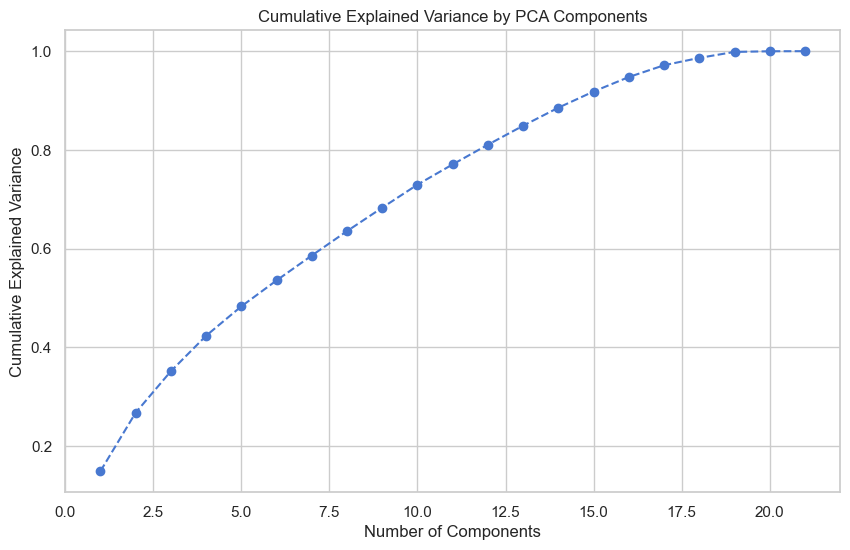

In [7]:
# PCA explained variance
pca_full = PCA().fit(X_scaled_df)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca_full.explained_variance_ratio_) + 1), 
         pca_full.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Number of components 
pca = PCA(n_components=10, random_state=42)
X_pca = pca.fit_transform(X_scaled_df)

# 5. Clustering Algorithm Enhancements


### a. Determining Optimal Number of Clusters Using Multiple Methods


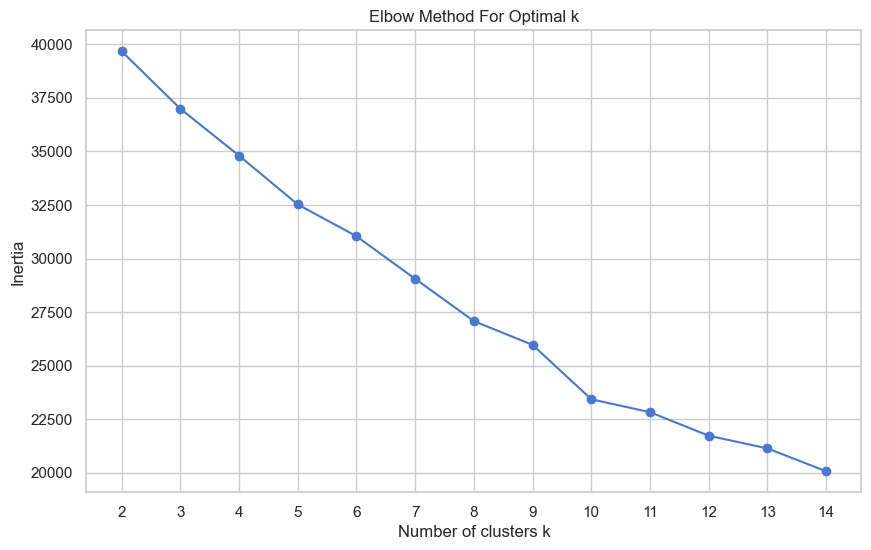

In [8]:
# Elbow Method
inertia = []
K_range = range(2, 15)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled_df)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')
plt.xticks(K_range)
plt.grid(True)
plt.show()

### Silhouette Analysis


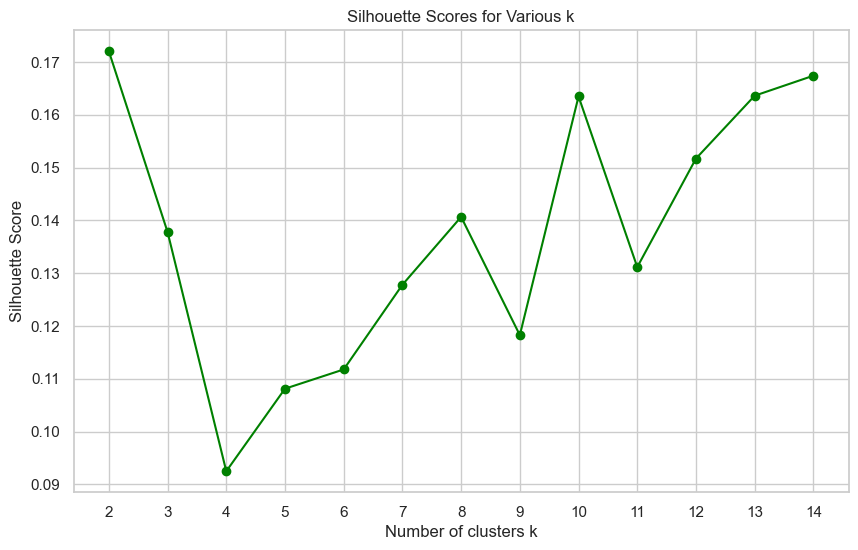


Selected Optimal Number of Clusters: 2


In [33]:
silhouette_scores = []
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled_df)
    score = silhouette_score(X_scaled_df, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, marker='o', color='green')
plt.title('Silhouette Scores for Various k')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette Score')
plt.xticks(K_range)
plt.grid(True)
plt.show()



optimal_k = K_range[int(np.argmax(silhouette_scores))]
print(f"\nSelected Optimal Number of Clusters: {optimal_k}")


### b. K-Means Clustering


In [10]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled_df)
df['KMeans_Cluster'] = kmeans_labels


### DBSCAN parameters might need tuning based on the dataset


In [11]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled_df)
df['DBSCAN_Cluster'] = dbscan_labels

### d. Hierarchical Clustering


In [31]:

# linked = linkage(X_scaled_df, method='ward')

# plt.figure(figsize=(15, 7))
# dendrogram(linked, truncate_mode='lastp', p=50, leaf_rotation=90., leaf_font_size=12., show_contracted=True)
# plt.title('Hierarchical Clustering Dendrogram')
# plt.xlabel('Cluster Size')
# plt.ylabel('Distance')
# plt.show()


### e. Gaussian Mixture Models (GMM)


In [13]:
gmm = GaussianMixture(n_components=optimal_k, random_state=42)
gmm_labels = gmm.fit_predict(X_scaled_df)
df['GMM_Cluster'] = gmm_labels

# 6. Enhanced Evaluation Metrics


In [34]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np

Ks = range(2, 13)
scores = []
for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = km.fit_predict(X_scaled_df)
    sil = silhouette_score(X_scaled_df, labels)
    db  = davies_bouldin_score(X_scaled_df, labels)
    ch  = calinski_harabasz_score(X_scaled_df, labels)
    scores.append((k, sil, db, ch))

best_by_sil = max(scores, key=lambda t: t[1])
print("k, silhouette, DB (lower better), CH (higher better):")
for t in scores: print(t)
print("\nBest k by silhouette:", best_by_sil)


k, silhouette, DB (lower better), CH (higher better):
(2, 0.17132858804581097, 2.701437434460885, 247.58339448855244)
(3, 0.08971628994663158, 2.4181957801004192, 207.49300546365362)
(4, 0.08219554236329228, 2.456354129056879, 185.36454527258968)
(5, 0.09036205414397029, 2.5374326648175307, 159.94267598362913)
(6, 0.09905889521807215, 2.182684886044328, 164.90069260252085)
(7, 0.10789128114704881, 1.9262606466723693, 172.23300151820436)
(8, 0.10245912421502323, 2.0002491000163856, 151.35717947761898)
(9, 0.11024858186826267, 1.8111341091707536, 162.98359664802553)
(10, 0.12481751850622162, 1.7118477552749503, 164.07736987332385)
(11, 0.13618167539771878, 1.5950430738341355, 179.28529820147202)
(12, 0.15120926041668614, 1.5300549819409703, 185.17010468565283)

Best k by silhouette: (2, 0.17132858804581097, 2.701437434460885, 247.58339448855244)


In [36]:
from sklearn.mixture import GaussianMixture
import numpy as np

ks = range(1, 13)
bics = []
for k in ks:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(X_scaled_df)
    bics.append(gmm.bic(X_scaled_df))
best_k_gmm = ks[int(np.argmin(bics))]
print("Best GMM components by BIC:", best_k_gmm)


Best GMM components by BIC: 12


### a. Silhouette Score for K-Means


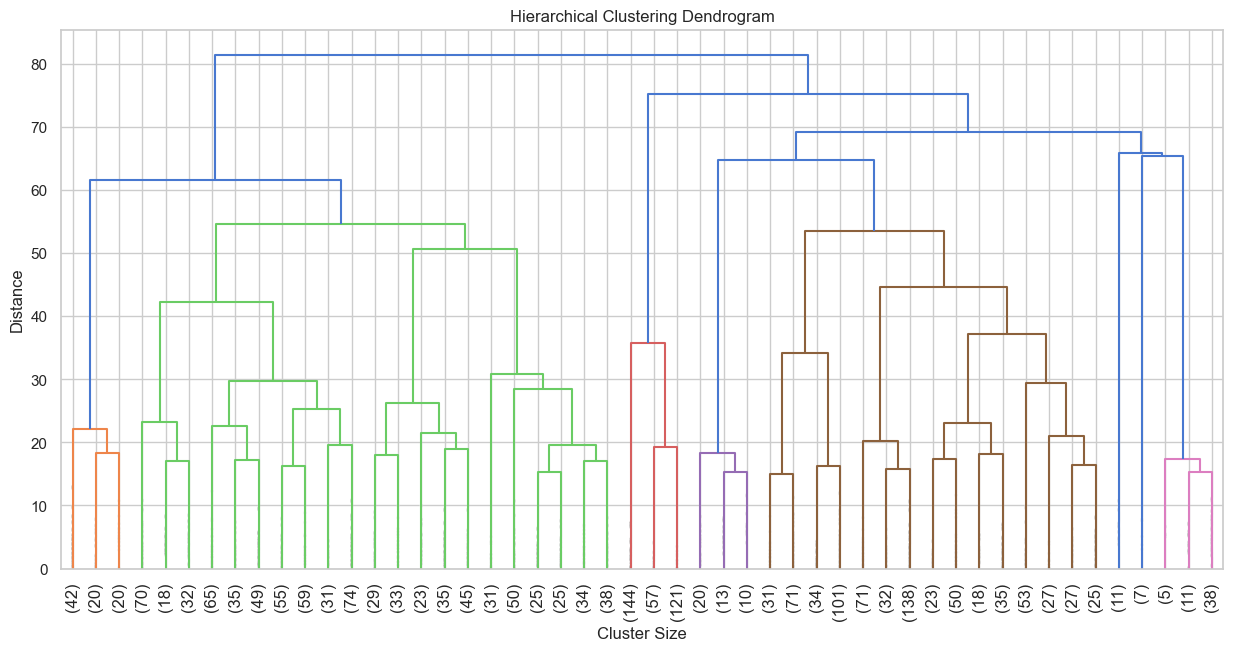


Average Silhouette Score for K-Means: 0.172


In [35]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled_df)
df['KMeans_Cluster'] = kmeans_labels


dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled_df)
df['DBSCAN_Cluster'] = dbscan_labels

linked = linkage(X_scaled_df, method='ward')

plt.figure(figsize=(15, 7))
dendrogram(linked, truncate_mode='lastp', p=50, leaf_rotation=90., leaf_font_size=12., show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.show()


gmm = GaussianMixture(n_components=optimal_k, random_state=42)
gmm_labels = gmm.fit_predict(X_scaled_df)
df['GMM_Cluster'] = gmm_labels

silhouette_avg_kmeans = silhouette_score(X_scaled_df, kmeans_labels)
print(f"\nAverage Silhouette Score for K-Means: {silhouette_avg_kmeans:.3f}")


### b. Davies-Bouldin Score for K-Means


In [15]:
db_score_kmeans = davies_bouldin_score(X_scaled_df, kmeans_labels)
print(f"Davies-Bouldin Score for K-Means: {db_score_kmeans:.3f}")



Davies-Bouldin Score for K-Means: 2.701


### c. Calinski-Harabasz Index for K-Means


In [16]:
ch_score_kmeans = calinski_harabasz_score(X_scaled_df, kmeans_labels)
print(f"Calinski-Harabasz Score for K-Means: {ch_score_kmeans:.3f}")


Calinski-Harabasz Score for K-Means: 247.588


### d. Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI) if true labels are available


In [17]:
# Note: Using 'NObeyesdad' as true labels for evaluation
ari_kmeans = adjusted_rand_score(y, kmeans_labels)
nmi_kmeans = normalized_mutual_info_score(y, kmeans_labels)
print(f"Adjusted Rand Index for K-Means: {ari_kmeans:.3f}")
print(f"Normalized Mutual Information for K-Means: {nmi_kmeans:.3f}")

# Similarly, compute metrics for GMM
silhouette_avg_gmm = silhouette_score(X_scaled_df, gmm_labels)
db_score_gmm = davies_bouldin_score(X_scaled_df, gmm_labels)
ch_score_gmm = calinski_harabasz_score(X_scaled_df, gmm_labels)
ari_gmm = adjusted_rand_score(y, gmm_labels)
nmi_gmm = normalized_mutual_info_score(y, gmm_labels)

print("\nGaussian Mixture Models (GMM) Evaluation:")
print(f"Average Silhouette Score for GMM: {silhouette_avg_gmm:.3f}")
print(f"Davies-Bouldin Score for GMM: {db_score_gmm:.3f}")
print(f"Calinski-Harabasz Score for GMM: {ch_score_gmm:.3f}")
print(f"Adjusted Rand Index for GMM: {ari_gmm:.3f}")
print(f"Normalized Mutual Information for GMM: {nmi_gmm:.3f}")

Adjusted Rand Index for K-Means: 0.167
Normalized Mutual Information for K-Means: 0.306

Gaussian Mixture Models (GMM) Evaluation:
Average Silhouette Score for GMM: 0.208
Davies-Bouldin Score for GMM: 2.871
Calinski-Harabasz Score for GMM: 210.437
Adjusted Rand Index for GMM: 0.072
Normalized Mutual Information for GMM: 0.146


# 7. Additional Visualizations


### a. PCA Visualization of K-Means Clusters


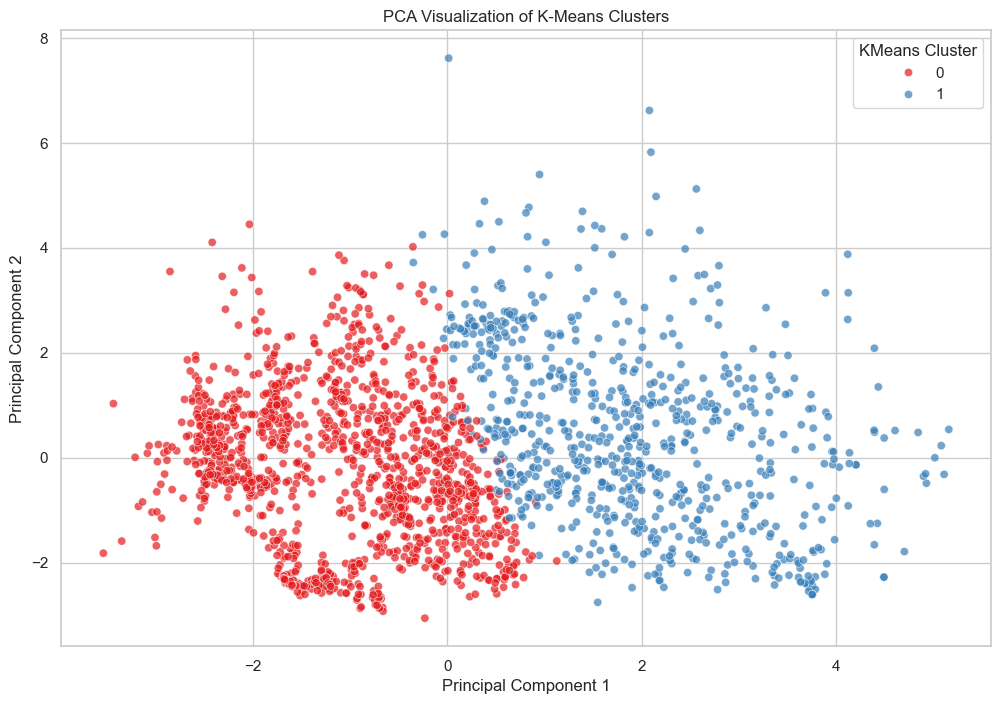

In [18]:
pca_2d = PCA(n_components=2, random_state=42)
principal_components = pca_2d.fit_transform(X_scaled_df)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['KMeans_Cluster'] = kmeans_labels
pca_df['GMM_Cluster'] = gmm_labels
pca_df['DBSCAN_Cluster'] = dbscan_labels
pca_df['True_Label'] = y

plt.figure(figsize=(12, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='KMeans_Cluster', palette='Set1', alpha=0.7)
plt.title('PCA Visualization of K-Means Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='KMeans Cluster')
plt.show()

### b. t-SNE Visualization of K-Means Clusters


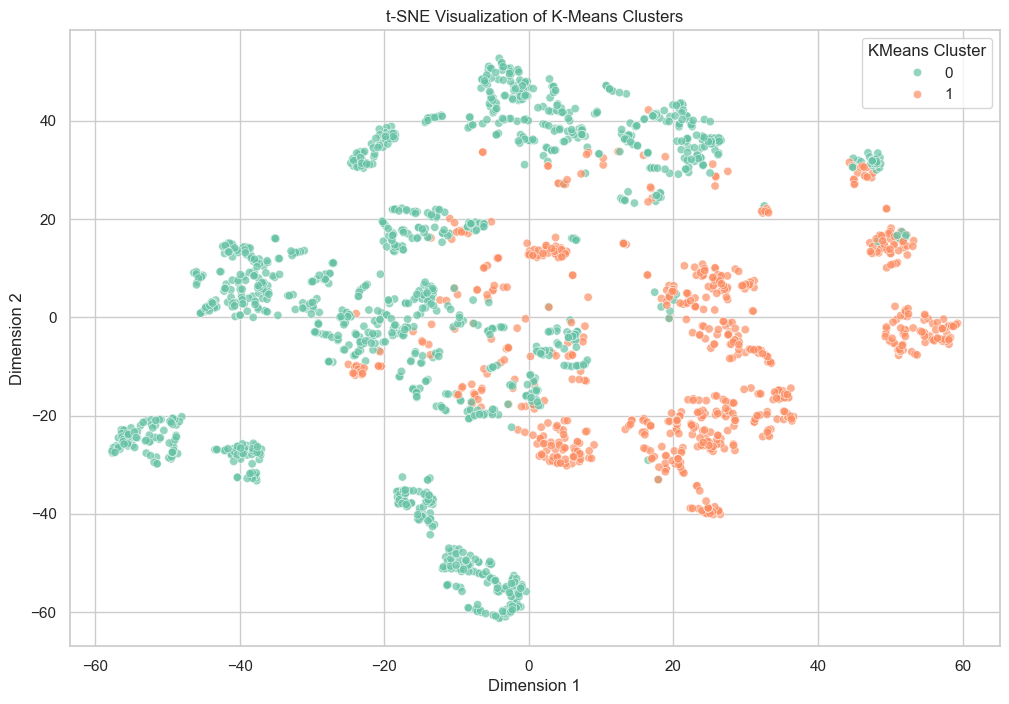

In [19]:
X_pca30 = PCA(n_components=min(30, X_scaled_df.shape[1]), svd_solver='randomized', random_state=42).fit_transform(X_scaled_df)
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=42)
tsne_results = tsne.fit_transform(X_pca30)

tsne_df = pd.DataFrame(data=tsne_results, columns=['Dim1', 'Dim2'])
tsne_df['KMeans_Cluster'] = kmeans_labels

plt.figure(figsize=(12, 8))
sns.scatterplot(data=tsne_df, x='Dim1', y='Dim2', hue='KMeans_Cluster', palette='Set2', alpha=0.7)
plt.title('t-SNE Visualization of K-Means Clusters')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(title='KMeans Cluster')
plt.show()

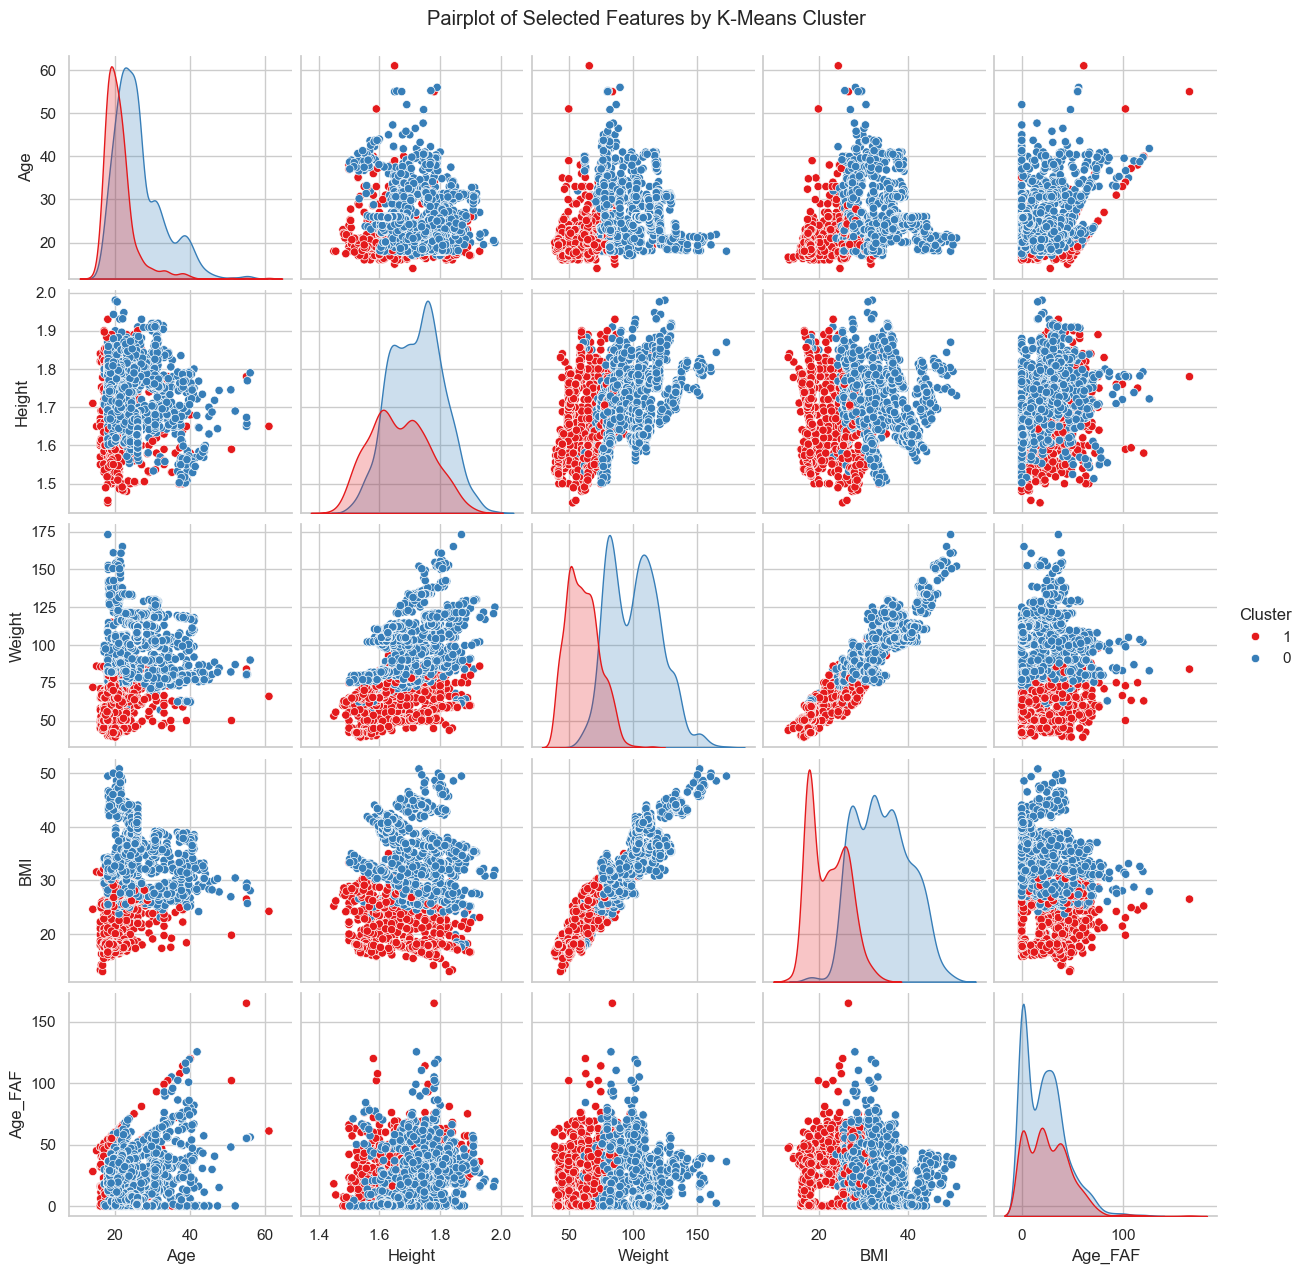

In [20]:
## c. Pairplot with Clusters
# Select relevant features for pairplot
selected_features = ['Age', 'Height', 'Weight', 'BMI', 'Age_FAF']
pair_df = df[selected_features].copy()
pair_df['Cluster'] = kmeans_labels.astype(str)

sns.pairplot(pair_df, hue='Cluster', palette='Set1', diag_kind='kde')
plt.suptitle('Pairplot of Selected Features by K-Means Cluster', y=1.02)
plt.show()

### d. Cluster-wise Distribution of Key Features (Violin Plot)


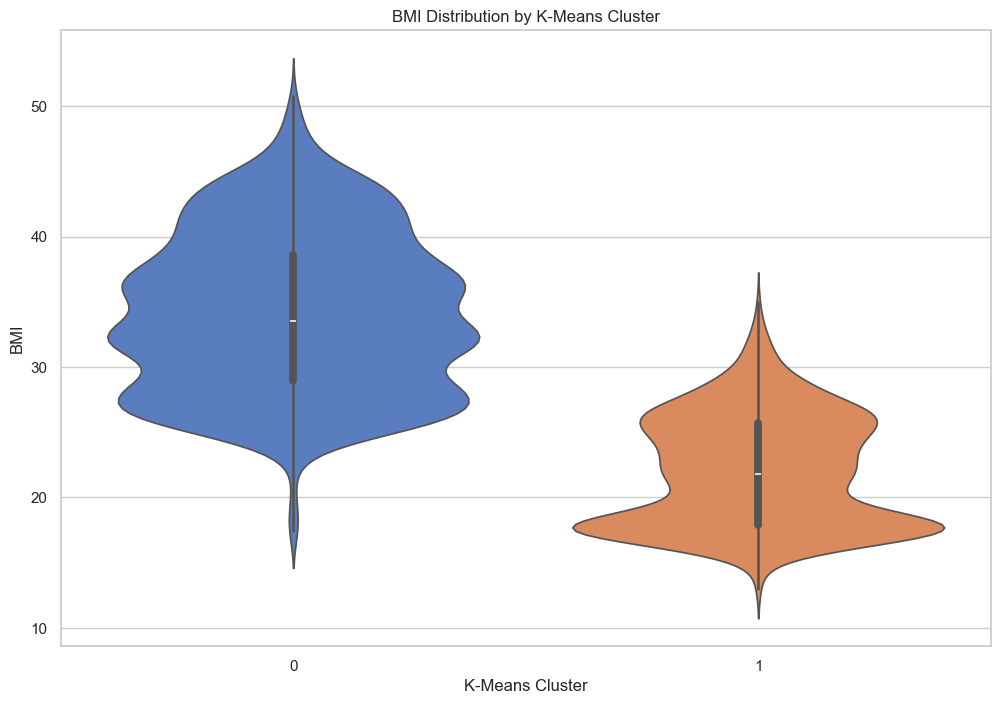

In [21]:
plt.figure(figsize=(12, 8))
sns.violinplot(data=df, x='KMeans_Cluster', y='BMI', palette='muted')
plt.title('BMI Distribution by K-Means Cluster')
plt.xlabel('K-Means Cluster')
plt.ylabel('BMI')
plt.show()

In [22]:
# Identify numeric columns in the original DataFrame (excluding 'KMeans_Cluster')
numeric_cols = X_scaled_df.columns.tolist()

In [23]:
from pandas.plotting import parallel_coordinates

# Sample the data for clarity
parallel_df = df.sample(n=200, random_state=42).copy()

# Extract the corresponding scaled numeric features
# Assuming 'X_scaled_df' is aligned with 'df' (same order), otherwise, ensure alignment
parallel_numeric = X_scaled_df.loc[parallel_df.index].copy()

# Add the 'KMeans_Cluster' as a string for the class column
parallel_numeric['KMeans_Cluster'] = parallel_df['KMeans_Cluster'].astype(str)

# Display the first few rows to verify
print("\nFirst 5 rows of the parallel coordinates DataFrame:")
print(parallel_numeric.head())



First 5 rows of the parallel coordinates DataFrame:
      Gender_Male  MTRANS_Bike  MTRANS_Motorbike  \
544     -1.011914    -0.057680         -0.072375   
1987    -1.011914    -0.057680         -0.072375   
420      0.988227    -0.057680         -0.072375   
527     -1.011914    -0.057680         -0.072375   
196      0.988227    17.336996         -0.072375   

      MTRANS_Public_Transportation  MTRANS_Walking      CALC      CAEC  \
544                       0.579721       -0.165078 -1.419172  1.834434   
1987                      0.579721       -0.165078  0.521160 -0.300346   
420                      -1.724969       -0.165078  0.521160 -0.300346   
527                       0.579721       -0.165078  0.521160  1.834434   
196                      -1.724969       -0.165078  0.521160 -0.300346   

       SMOKE       SCC  family_history_with_overweight  ...    Height  \
544  -0.1459 -0.218272                        0.472291  ...  0.582108   
1987 -0.1459 -0.218272                     

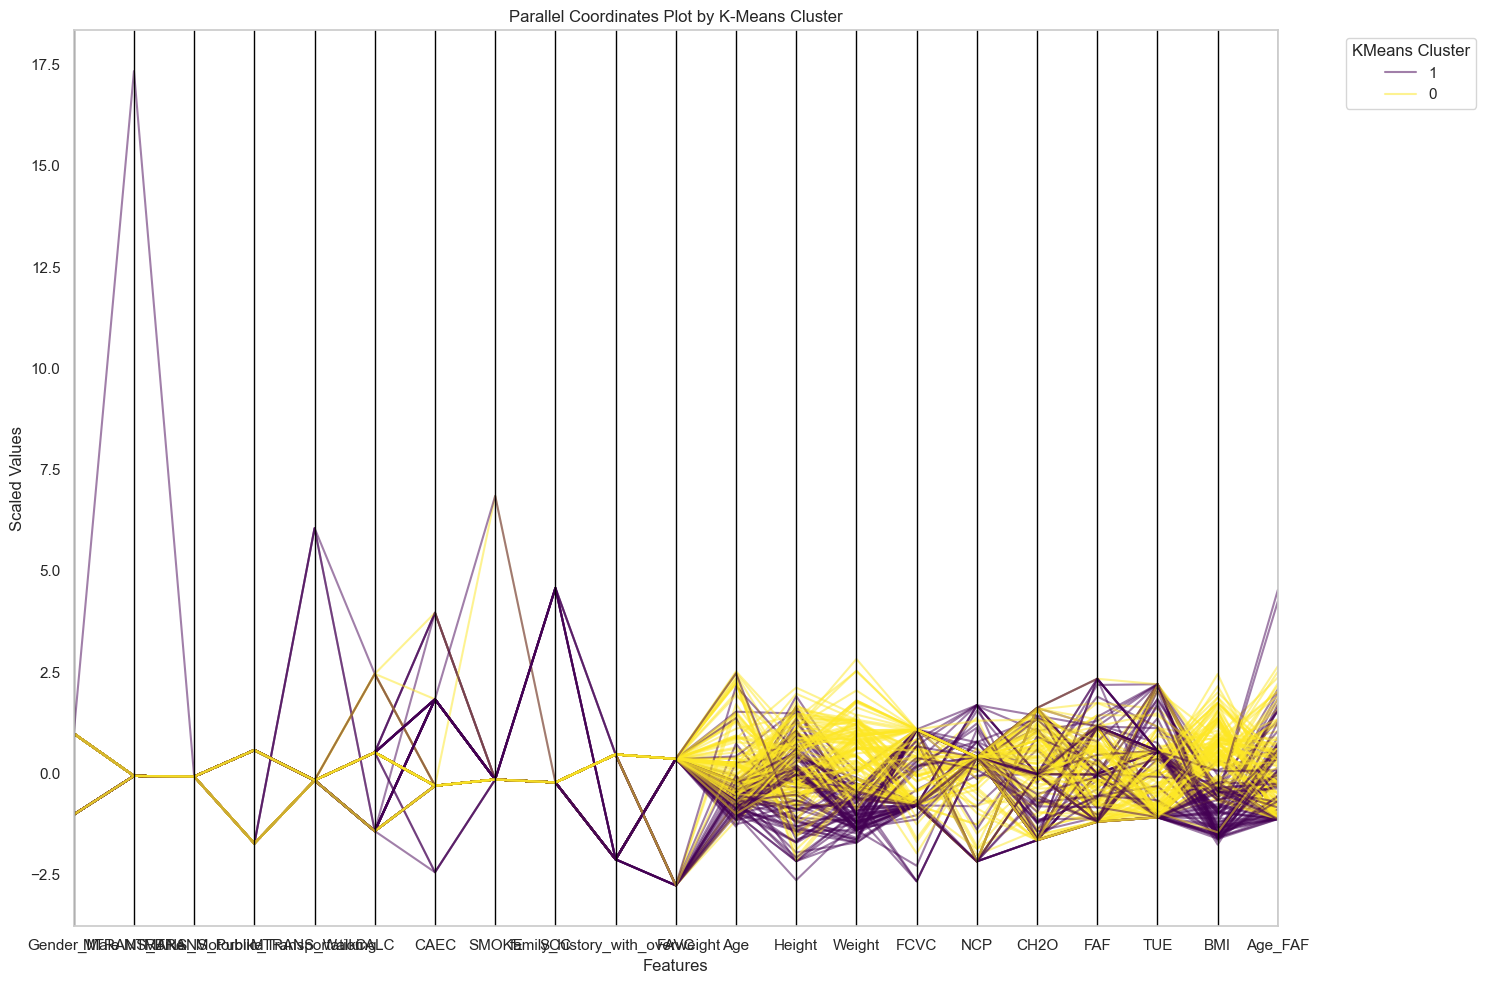

In [24]:
plt.figure(figsize=(15, 10))
parallel_coordinates(parallel_numeric, class_column='KMeans_Cluster', colormap='viridis', alpha=0.5)
plt.title('Parallel Coordinates Plot by K-Means Cluster')
plt.xlabel('Features')
plt.ylabel('Scaled Values')
plt.legend(title='KMeans Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### f. Hierarchical Clustering Dendrogram


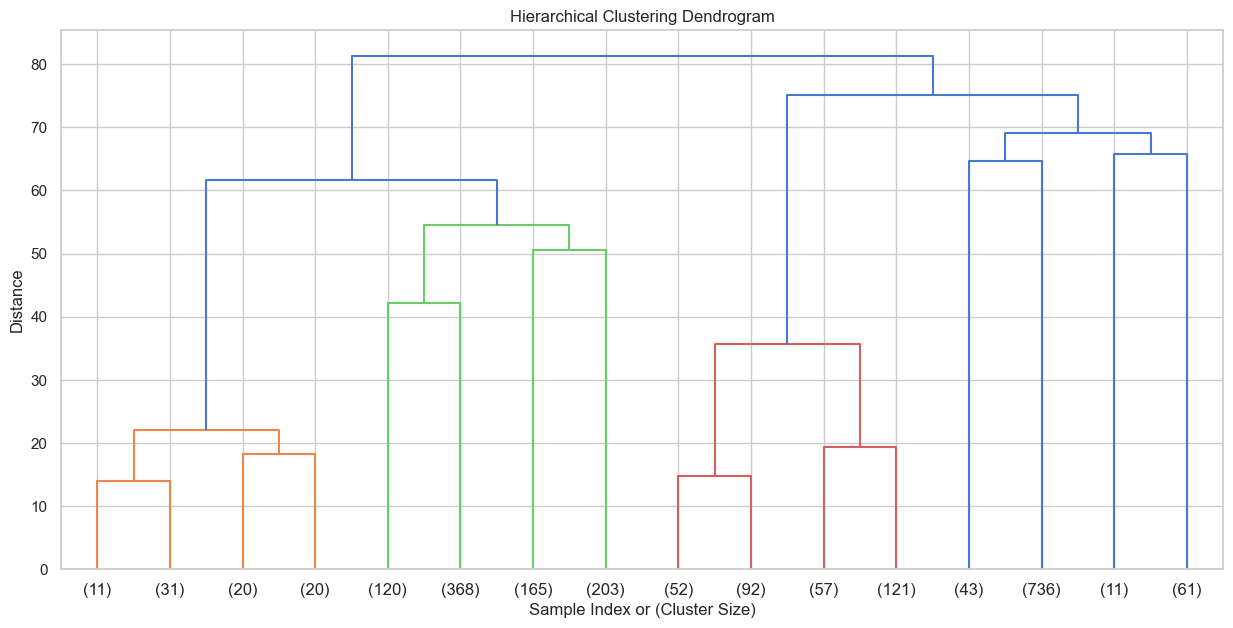

In [25]:
plt.figure(figsize=(15, 7))
dendrogram(linked, truncate_mode='level', p=3)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index or (Cluster Size)')
plt.ylabel('Distance')
plt.show()

## g. Silhouette Plot for K-Means Clusters


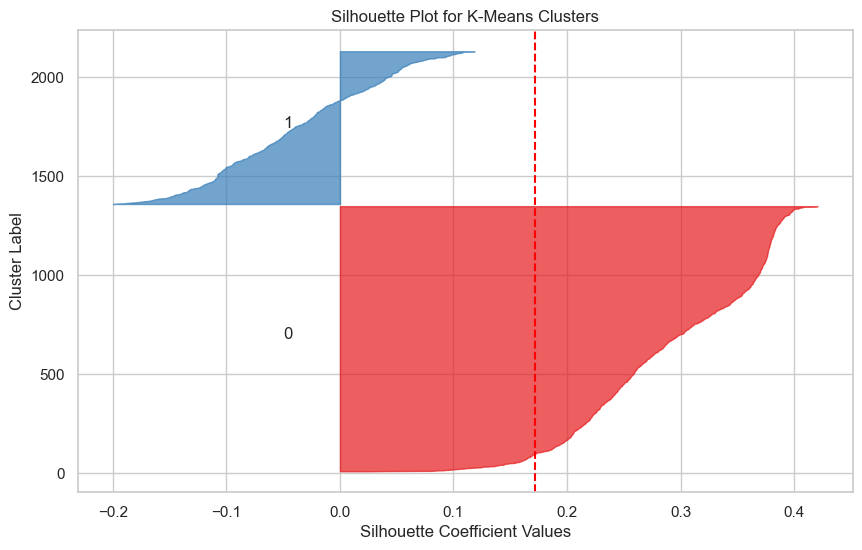

In [26]:
silhouette_vals = silhouette_samples(X_scaled_df, kmeans_labels)
plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(optimal_k):
    ith_cluster_silhouette_values = silhouette_vals[kmeans_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = sns.color_palette("Set1")[i]
    plt.fill_betweenx(range(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

plt.axvline(x=silhouette_avg_kmeans, color="red", linestyle="--")
plt.title("Silhouette Plot for K-Means Clusters")
plt.xlabel("Silhouette Coefficient Values")
plt.ylabel("Cluster Label")
plt.show()

# 8. Interpreting Clusters with Respect to Obesity Levels


### a. Analyzing Cluster Purity



Confusion Matrix between K-Means Clusters and True Obesity Levels:
NObeyesdad      Insufficient_Weight  Normal_Weight  Obesity_Type_I  \
KMeans_Cluster                                                       
0                                 6             17             332   
1                               266            270              19   

NObeyesdad      Obesity_Type_II  Obesity_Type_III  Overweight_Level_I  \
KMeans_Cluster                                                          
0                           296               324                 156   
1                             1                 0                 134   

NObeyesdad      Overweight_Level_II  
KMeans_Cluster                       
0                               208  
1                                82  


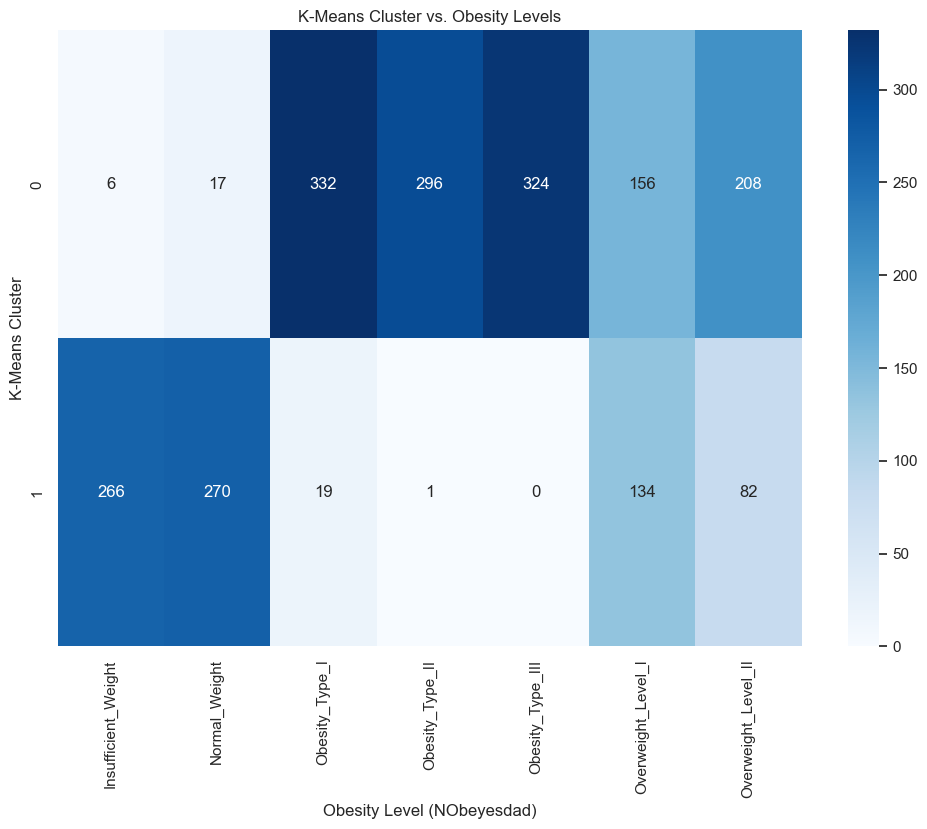

In [27]:
conf_matrix = pd.crosstab(df['KMeans_Cluster'], df['NObeyesdad'])
print("\nConfusion Matrix between K-Means Clusters and True Obesity Levels:")
print(conf_matrix)

# Visualize confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('K-Means Cluster vs. Obesity Levels')
plt.xlabel('Obesity Level (NObeyesdad)')
plt.ylabel('K-Means Cluster')
plt.show()

### b. Understanding Cluster Profiles


In [28]:
# Numerical Features Summary
numeric_features = ['Age', 'Height', 'Weight', 'BMI', 'Age_FAF']
num_summary = df.groupby('KMeans_Cluster')[numeric_features].mean()
print("\nNumerical Summary by K-Means Cluster:")
print(num_summary)

# Categorical Features Summary
categorical_features_summary = ['CALC', 'CAEC', 'SMOKE', 'SCC', 
                                'family_history_with_overweight', 'FAVC', 'MTRANS']
cat_summary = df.groupby('KMeans_Cluster')[categorical_features_summary].agg(lambda x: x.mode()[0])
print("\nCategorical Summary by K-Means Cluster:")
print(cat_summary)



Numerical Summary by K-Means Cluster:
                      Age   Height      Weight        BMI    Age_FAF
KMeans_Cluster                                                      
0               26.210710  1.72223  101.374581  34.150054  22.518159
1               21.020412  1.66603   60.936017  21.982012  25.971291

Categorical Summary by K-Means Cluster:
                     CALC       CAEC SMOKE SCC family_history_with_overweight  \
KMeans_Cluster                                                                  
0               Sometimes  Sometimes    no  no                            yes   
1               Sometimes  Sometimes    no  no                            yes   

               FAVC                 MTRANS  
KMeans_Cluster                              
0               yes  Public_Transportation  
1               yes  Public_Transportation  


# 9. Other Techniques

### a. Feature Importance in Clustering


K-Means Cluster Centers (Feature-wise):
   Gender_Male  MTRANS_Bike  MTRANS_Motorbike  MTRANS_Public_Transportation  \
0     0.097948    -0.044689         -0.062002                     -0.043355   
1    -0.169886     0.077512          0.107539                      0.075197   

   MTRANS_Walking      CALC      CAEC     SMOKE       SCC  \
0       -0.127899  0.144396 -0.254111 -0.015208 -0.214687   
1        0.221834 -0.250449  0.440744  0.026377  0.372366   

   family_history_with_overweight  ...       Age    Height    Weight  \
0                        0.445215  ...  0.299176  0.220326  0.564771   
1                       -0.772206  ... -0.518907 -0.382146 -0.979571   

       FCVC       NCP      CH2O       FAF       TUE       BMI   Age_FAF  
0  0.085131  0.004364  0.098895 -0.151745 -0.097312  0.555581 -0.059513  
1 -0.147656 -0.007570 -0.171528  0.263196  0.168783 -0.963631  0.103222  

[2 rows x 21 columns]


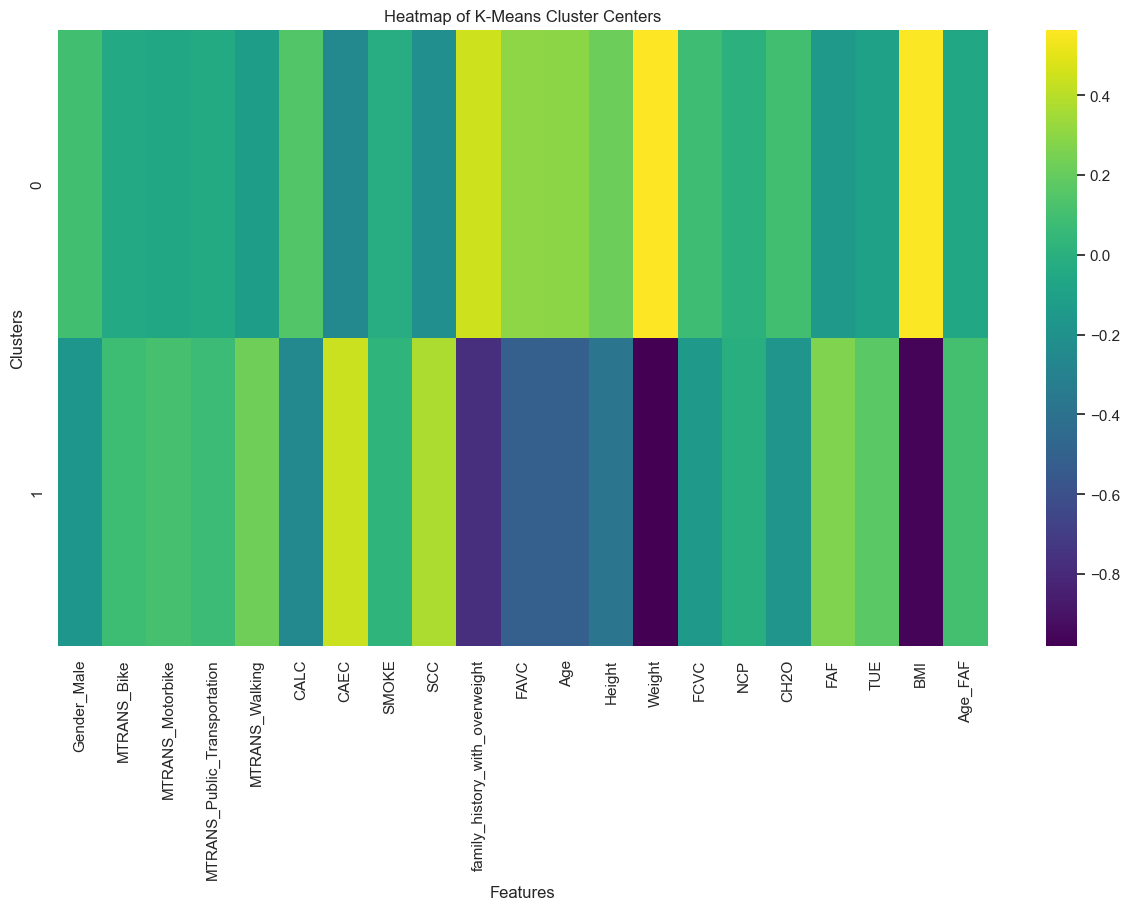

In [29]:

# Use columns of X_scaled_df as feature names
processed_feature_names = X_scaled_df.columns.tolist()

# create  DataFrame for cluster centers
kmeans_centers = pd.DataFrame(kmeans.cluster_centers_, columns=processed_feature_names)

# Verify cluster centers
print("\nK-Means Cluster Centers (Feature-wise):")
print(kmeans_centers)


# visualize cluster centers
plt.figure(figsize=(15, 8))
sns.heatmap(kmeans_centers, annot=False, cmap='viridis')
plt.title('Heatmap of K-Means Cluster Centers')
plt.xlabel('Features')
plt.ylabel('Clusters')
plt.show()

### b. Cluster Balancing 



K-Means Cluster Distribution:
0    1339
1     772
Name: KMeans_Cluster, dtype: int64


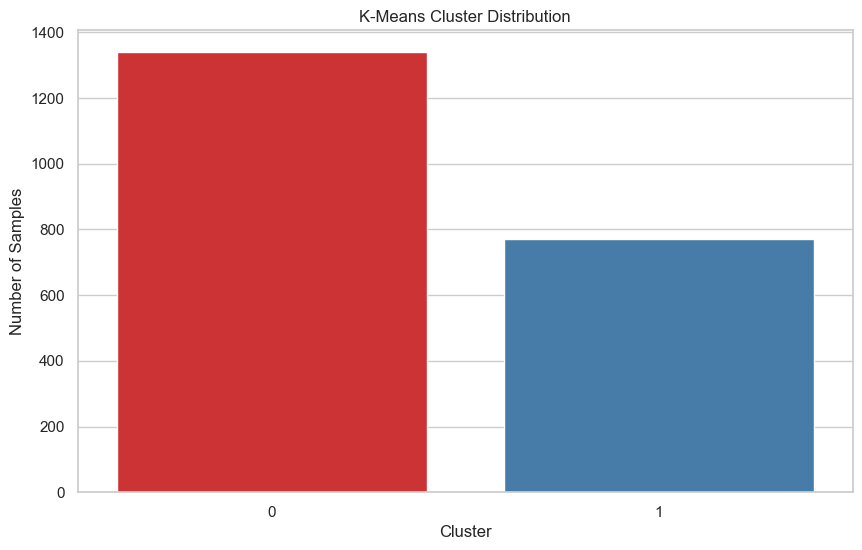

In [30]:
# Check distribution of clusters
cluster_counts = df['KMeans_Cluster'].value_counts().sort_index()
print("\nK-Means Cluster Distribution:")
print(cluster_counts)

# Plot cluster distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='Set1')
plt.title('K-Means Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Number of Samples')
plt.show()